# Part 1.1: Estimate the value function

In [ ]:
import numpy as np
from scipy.linalg import solve

## Helper function

In [ ]:
# Helper function to convert (row, col) to state index
def state_index(row, col):
    return row * grid_size + col

# Function to get next state and reward given the current state and action
def get_next_state_and_reward(row, col, action):
    # Define special squares
    blue_square = (0, 1)
    green_square = (0, 4)
    red_square = (3, 2)
    yellow_square = (4, 4)

    if action == 'up':
        next_row, next_col = (row - 1, col) if row > 0 else (row, col)
    elif action == 'down':
        next_row, next_col = (row + 1, col) if row < grid_size - 1 else (row, col)
    elif action == 'left':
        next_row, next_col = (row, col - 1) if col > 0 else (row, col)
    elif action == 'right':
        next_row, next_col = (row, col + 1) if col < grid_size - 1 else (row, col)

    if (row, col) == blue_square:
        return red_square[0], red_square[1], 5
    elif (row, col) == green_square:
        if np.random.rand() < 0.5:
            return red_square[0], red_square[1], 2.5
        else:
            return yellow_square[0], yellow_square[1], 2.5
    elif (row == next_row) and (col == next_col):
        return next_row, next_col, -0.5
    else:
        return next_row, next_col, 0.0

## (a) Solving the system of Bellman equations

In [ ]:
"""Solving the system of Bellman equations for the gridworld problem."""
def value_Bellman(grid_size, gamma):
  # Define parameters
  num_states = grid_size * grid_size
  actions = ['up', 'down', 'left', 'right']
  reward_off_grid = -0.5

  # Define special squares
  blue_square = (0, 1)
  green_square = (0, 4)
  red_square = (3, 2)
  yellow_square = (4, 4)

  # Helper function to convert (row, col) to state index
  def state_index(row, col):
      return row * grid_size + col

  # Initialize transition and reward matrices
  P = np.zeros((num_states, num_states, len(actions)))
  R = np.zeros((num_states, len(actions)))

# Define transition probabilities and rewards
  for row in range(grid_size):
    for col in range(grid_size):
        state = state_index(row, col)
        for action in actions:
            if action == 'up':
                next_row, next_col = (row - 1, col) if row > 0 else (row, col)
            elif action == 'down':
                next_row, next_col = (row + 1, col) if row < grid_size - 1 else (row, col)
            elif action == 'left':
                next_row, next_col = (row, col - 1) if col > 0 else (row, col)
            elif action == 'right':
                next_row, next_col = (row, col + 1) if col < grid_size - 1 else (row, col)

            next_state = state_index(next_row, next_col)


            if (row, col) == blue_square:
                R[state, actions.index(action)] = 5
                next_state = state_index(*red_square)
                P[state, next_state, actions.index(action)] = 1
                continue
            elif (row, col) == green_square:
                R[state, actions.index(action)] = 2.5
                next_state_red = state_index(*red_square)
                next_state_yellow = state_index(*yellow_square)
                P[state, next_state_red, actions.index(action)] = 0.5
                P[state, next_state_yellow, actions.index(action)] = 0.5
                continue

            if (row == next_row) and (col == next_col):
                R[state, actions.index(action)] = reward_off_grid
                P[state, next_state, actions.index(action)] = 1
                continue
            else:
                R[state, actions.index(action)] = 0.0
                P[state, next_state, actions.index(action)] = 1
                continue

  # Construct the system of Bellman equations
  A = np.eye(num_states)
  b = np.zeros(num_states)

  for state in range(num_states):
    for action in actions:
        action_index = actions.index(action)
        for next_state in range(num_states):
            A[state, next_state] -= gamma * P[state, next_state, action_index] *0.25
        b[state] += 0.25 * R[state, action_index]

  # Solve the linear system A * V = b
  V = solve(A, b)

  # return
  return V

## (b) Using iterative policy evaluation

In [ ]:
"""Solving the gridworld problem using iterative policy evaluation."""
def iterative_policy_iteration(grid_size, gamma):
  num_states = grid_size * grid_size
  actions = ['up', 'down', 'left', 'right']
  threshold = 1e-6
  green_square = (0, 4)
  red_square = (3, 2)
  yellow_square = (4, 4)

  # Initialize value function
  V = np.zeros((grid_size, grid_size))

  # Iterative policy evaluation
  iteration = 0
  while True:
    delta = 0
    new_V = np.copy(V)
    for row in range(grid_size):
        for col in range(grid_size):
            v = V[row, col]
            value_sum = 0
            for action in actions:
                next_row, next_col, reward = get_next_state_and_reward(row, col, action)
                if (row,col) != green_square:
                  value_sum += 0.25 * (reward + gamma * V[next_row, next_col])
                else:
                  value_sum += 0.25*(0.5 * (reward + gamma * V[red_square[0], red_square[1]]) \
                               + 0.5 * (reward + gamma * V[yellow_square[0], yellow_square[1]]))
            new_V[row, col] = value_sum
            delta = max(delta, abs(v - new_V[row, col]))
    V = new_V
    iteration += 1
    if delta < threshold:
        break

  # return
  return V, iteration, delta

## (c) Using value iteration

In [ ]:
def value_iteration(grid_size, gamma):
  num_states = grid_size * grid_size
  actions = ['up', 'down', 'left', 'right']
  threshold = 1e-6
  reward_off_grid = -0.5

  # Define special squares
  blue_square = (0, 1)
  green_square = (0, 4)
  red_square = (3, 2)
  yellow_square = (4, 4)

  # Initialize value function
  V = np.zeros((grid_size, grid_size))
  policy = np.zeros((grid_size, grid_size), dtype=int)

  # Helper function to convert (row, col) to state index
  def state_index(row, col):
    return row * grid_size + col

  # Function to get next state and reward given the current state and action
  def get_next_state_and_reward(row, col, action):
    if action == 'up':
        next_row, next_col = (row - 1, col) if row > 0 else (row, col)
    elif action == 'down':
        next_row, next_col = (row + 1, col) if row < grid_size - 1 else (row, col)
    elif action == 'left':
        next_row, next_col = (row, col - 1) if col > 0 else (row, col)
    elif action == 'right':
        next_row, next_col = (row, col + 1) if col < grid_size - 1 else (row, col)

    if (row, col) == blue_square:
        return red_square[0], red_square[1], 5
    elif (row, col) == green_square:
        return red_square[0], red_square[1], 2.5, yellow_square[0], yellow_square[1], 2.5
    elif (row == next_row) and (col == next_col):
        return next_row, next_col, reward_off_grid
    else:
        return next_row, next_col, 0.0

  # Value iteration
  iteration = 0
  while True:
    delta = 0
    new_V = np.copy(V)
    for row in range(grid_size):
        for col in range(grid_size):
            v = V[row, col]
            value_sum = []
            for action in actions:
                result = get_next_state_and_reward(row, col, action)
                if (row, col) == green_square:
                    next_row_red, next_col_red = red_square
                    next_row_yellow, next_col_yellow = yellow_square
                    reward_red, reward_yellow = 2.5, 2.5
                    value_sum.append((reward_red + gamma * V[next_row_red, next_col_red]) * 0.5 +
                                      (reward_yellow + gamma * V[next_row_yellow, next_col_yellow]) * 0.5)
                    continue
                else:
                    next_row, next_col, reward = result
                    value_sum.append(reward + gamma * V[next_row, next_col])
            value_sum = np.array(value_sum)
            new_V[row, col] = np.max(value_sum)
            policy[row, col] = np.argmax(value_sum)
            delta = max(delta, abs(v - new_V[row, col]))
    V = new_V
    iteration += 1
    if delta < threshold:
        break
  policy_symbols = np.array([['↑', '↓', '←', '→'][policy[row, col]] for row in range(grid_size) for col in range(grid_size)])
  policy_symbols = policy_symbols.reshape((grid_size, grid_size))
  return V, iteration, delta, policy_symbols

## Algorithms execution

In [ ]:
grid_size = 5
gamma = 0.95
V_Bellman = value_Bellman(grid_size, gamma)
V_ip, iter_ip, delta_ip = iterative_policy_iteration(grid_size, gamma)
V_vi, iter_vi, delta_vi, _ = value_iteration(grid_size, gamma)

## Plot the result

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot(array):
# Step 2: Use matplotlib to create a plot and display the array values within the squares
  fig, ax = plt.subplots()

  # Custom colors for specific squares
  special_colors = {
      (0, 1): 'blue',
      (0, 4): 'green',
      (3, 2): 'red',
      (4, 4): 'yellow'
  }

  # Loop over data dimensions and create text annotations and colored squares.
  for (i, j), val in np.ndenumerate(array):
      # Default color is white
      color = 'white'
      if (i, j) in special_colors:
          color = special_colors[(i, j)]
      # Add a colored rectangle for all cells, default or special color
      ax.add_patch(patches.Rectangle((j-0.5, 4-i-0.5), 1, 1, fill=True, color=color, edgecolor='black'))
      ax.text(j, 4-i, f'{val}', ha='center', va='center', color='black')

  # Hide the x and y axes
  ax.set_xticks(np.arange(-0.5, 5, 1), minor=True)
  ax.set_yticks(np.arange(-0.5, 5, 1), minor=True)
  ax.grid(which="minor", color="black", linestyle='-', linewidth=2)
  ax.tick_params(which="minor", size=0)

  ax.set_xticks([])
  ax.set_yticks([])

  return fig,ax


### Result from solving the system of Bellman equations

<ipython-input-56-a4dcf5ff2754>:23: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(patches.Rectangle((j-0.5, 4-i-0.5), 1, 1, fill=True, color=color, edgecolor='black'))


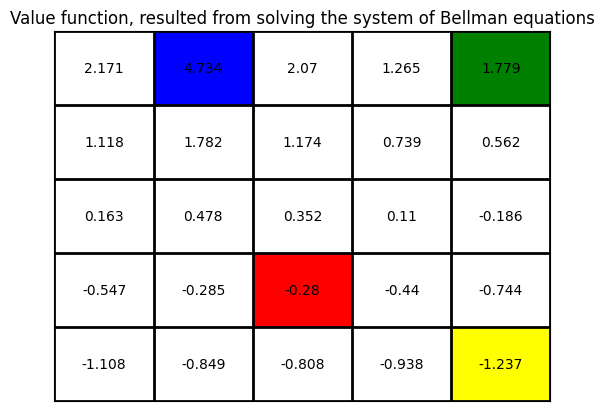

In [ ]:
plot_Bellman,ax_Bellman = plot(np.round(V_Bellman.reshape(grid_size, grid_size), decimals=3))
ax_Bellman.title.set_text('Value function, resulted from solving the system of Bellman equations')
plt.show()

### Result from iterative policy evaluation

<ipython-input-56-a4dcf5ff2754>:23: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(patches.Rectangle((j-0.5, 4-i-0.5), 1, 1, fill=True, color=color, edgecolor='black'))


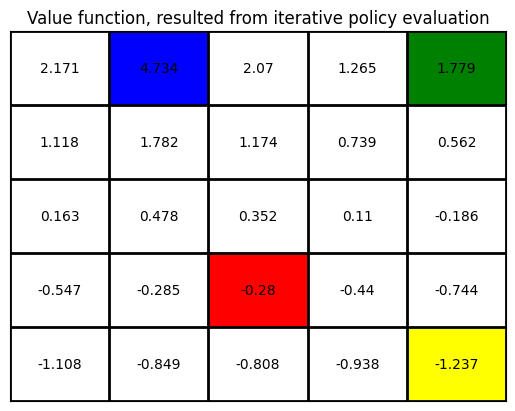

Iterative policy evaluation converged after 172 iterations
Delta = 9.525779267605117e-07


In [ ]:
plot_ip,ax_ip = plot(np.round(V_ip, decimals=3))
ax_ip.title.set_text('Value function, resulted from iterative policy evaluation')
plt.show()


print(f"Iterative policy evaluation converged after {iter_ip} iterations")
print(f"Delta = {delta_ip}")

### Result from value iteration method

<ipython-input-56-a4dcf5ff2754>:23: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(patches.Rectangle((j-0.5, 4-i-0.5), 1, 1, fill=True, color=color, edgecolor='black'))


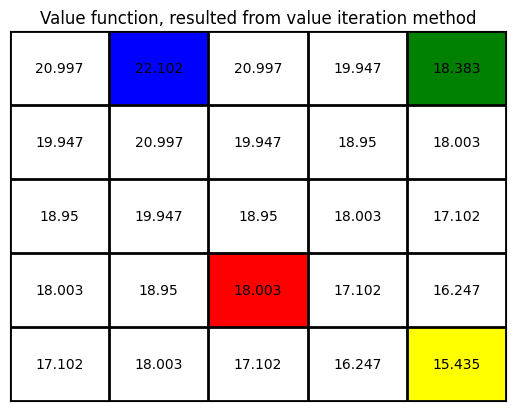

Value estimation method converged after 302 iterations
Delta = 9.857690912440376e-07


In [ ]:
plot_vi,ax_vi = plot(np.round(V_vi, decimals=3))
ax_vi.title.set_text('Value function, resulted from value iteration method')
plt.show()

print(f"Value estimation method converged after {iter_vi} iterations")
print(f"Delta = {delta_vi}")

# Part 1.2: Determine the optimal policy

## Helper function

In [3]:
def get_next_state_and_reward(row, col, action):
    # Define special squares
    blue_square = (0, 1)
    green_square = (0, 4)
    red_square = (3, 2)
    yellow_square = (4, 4)

    next_row, next_col = (0,0)

    if action == 0:
        next_row, next_col = (row - 1, col) if row > 0 else (row, col)
    elif action == 1:
        next_row, next_col = (row + 1, col) if row < grid_size - 1 else (row, col)
    elif action == 2:
        next_row, next_col = (row, col - 1) if col > 0 else (row, col)
    elif action == 3:
        next_row, next_col = (row, col + 1) if col < grid_size - 1 else (row, col)

    if (row, col) == blue_square:
        return red_square[0], red_square[1], 5
    elif (row, col) == green_square:
        if np.random.rand() < 0.5:
            return red_square[0], red_square[1], 2.5
        else:
            return yellow_square[0], yellow_square[1], 2.5
    elif (row == next_row) and (col == next_col):
        return next_row, next_col, -0.5
    else:
        return next_row, next_col, 0.0

In [9]:
# This funciton is used to determine the optimal policy from the value of each square, calculated by different method

def optimal_policy(V, grid_size, gamma):
    num_states = grid_size * grid_size
    actions = [0,1,2,3]

    # Define special squares
    blue_square = (0, 1)
    green_square = (0, 4)
    red_square = (3, 2)
    yellow_square = (4, 4)

    policy = np.zeros((grid_size, grid_size), dtype=int)

    for row in range(grid_size):
        for col in range(grid_size):
            action_values = []
            for action in actions:
                if (row, col) == green_square:
                  next_row_red, next_col_red = red_square
                  next_row_yellow, next_col_yellow = yellow_square
                  reward_red, reward_yellow = 2.5, 2.5
                  action_values.append(0.5 * (reward_red + gamma * V[next_row_red, next_col_red]) +
                                        0.5 * (reward_yellow + gamma * V[next_row_yellow, next_col_yellow]))
                else:
                  next_row, next_col, reward = get_next_state_and_reward(row, col, action)
                  action_values.append(reward + gamma * V[next_row, next_col])
            policy[row, col] = np.argmax(action_values)

    return policy


## Bellman optimality equation method

In [ ]:
import cvxpy as cvx
import numpy as np

def optimal_Bellman(grid_size, gamma):
  num_states = grid_size * grid_size
  actions = ['up', 'down', 'left', 'right']
  reward_off_grid = -0.5

  # Define special squares
  blue_square = (0, 1)
  green_square = (0, 4)
  red_square = (3, 2)
  yellow_square = (4, 4)


  # Helper function to convert (row, col) to state index
  def state_index(row, col):
        return row * grid_size + col

    # Initialize transition and reward matrices
  P = np.zeros((num_states, num_states, len(actions)))
  R = np.zeros((num_states, len(actions)))

  # Define transition probabilities and rewards
  for row in range(grid_size):
      for col in range(grid_size):
          state = state_index(row, col)
          for action in actions:
              if action == 'up':
                  next_row, next_col = (row - 1, col) if row > 0 else (row, col)
              elif action == 'down':
                  next_row, next_col = (row + 1, col) if row < grid_size - 1 else (row, col)
              elif action == 'left':
                  next_row, next_col = (row, col - 1) if col > 0 else (row, col)
              elif action == 'right':
                  next_row, next_col = (row, col + 1) if col < grid_size - 1 else (row, col)

              next_state = state_index(next_row, next_col)


              if (row, col) == blue_square:
                  R[state, actions.index(action)] = 5
                  next_state = state_index(*red_square)
                  P[state, next_state, actions.index(action)] = 1
                  continue
              elif (row, col) == green_square:
                  R[state, actions.index(action)] = 2.5
                  next_state_red = state_index(*red_square)
                  next_state_yellow = state_index(*yellow_square)
                  P[state, next_state_red, actions.index(action)] = 0.5
                  P[state, next_state_yellow, actions.index(action)] = 0.5
                  continue

              if (row == next_row) and (col == next_col):
                  R[state, actions.index(action)] = reward_off_grid
                  P[state, next_state, actions.index(action)] = 1
                  continue
              else:
                  R[state, actions.index(action)] = 0.0
                  P[state, next_state, actions.index(action)] = 1
                  continue
  # Determine the constraints for the optimization problem
  Value = cvx.Variable(num_states)
  constraint = []

  for state in range(num_states):
    bellman = []
    for action in actions:
      action_index = actions.index(action)
      temp = 0
      for next_state in range(num_states):
            temp += P[state, next_state, action_index] * (R[state, actions.index(action)] + gamma * Value[next_state])
      bellman.append(temp)

    constraint.append(Value[state] >= cvx.max(cvx.hstack(bellman)))

  objective = cvx.Minimize(cvx.sum(Value))

  # Find the optimal value function by solving the convex optimization problem
  problem = cvx.Problem(objective, constraint)
  problem.solve()
  V_optimal = (Value.value).reshape((grid_size, grid_size))

  # Determine the optimal policy
  policy = optimal_policy(V_optimal, grid_size=grid_size, gamma=gamma)
  policy_symbols = np.array([['↑', '↓', '←', '→'][policy[row, col]] for row in range(grid_size) for col in range(grid_size)])
  policy_symbols = policy_symbols.reshape((grid_size, grid_size))

  print("Curvative of value: ", Value[0].curvature)
  print("Curvative of con: ", cvx.max(cvx.hstack(bellman)).curvature)

  return policy_symbols, V_optimal


## Policy iteration with iterative policy evaluation

In [7]:
import numpy as np
import random

# Define parameters
grid_size = 5
gamma = 0.95
actions = ['up', 'down', 'left', 'right']
reward_off_grid = -0.5
reward_move = 0

# Define special squares
blue_square = (0, 1)
green_square = (0, 4)
red_square = (3, 2)
yellow_square = (4, 4)

def policy_evaluation(policy, value_function, gamma, blue_square, green_square, theta=1e-6):
    while True:
        delta = 0
        new_value_function = np.copy(value_function)
        for row in range(grid_size):
            for col in range(grid_size):
                v = value_function[row, col]
                action = policy[row, col]
                next_row, next_col, reward = get_next_state_and_reward(row, col, action)
                if (row,col)==green_square:
                  new_value_function[row, col] = (0.5*(reward + gamma * value_function[yellow_square[0], yellow_square[1]])\
                                                + 0.5*(reward + gamma * value_function[red_square[0], red_square[1]]))
                else:
                  new_value_function[row, col] = (reward + gamma * value_function[next_row, next_col])
                delta = max(delta, abs(v - new_value_function[row, col]))
        value_function = new_value_function
        if delta < theta:
            break
    return value_function

def policy_improvement(policy, value_function, gamma, blue_square, green_square):
    policy_stable = True
    for row in range(grid_size):
        for col in range(grid_size):
            old_action = policy[row, col]
            action_values = np.zeros(len(actions))
            for action in range(len(actions)):
                next_row, next_col, reward = get_next_state_and_reward(row, col, action)
                if (row,col)==green_square:
                  action_values[action] = 0.5*(reward + gamma * value_function[yellow_square[0], yellow_square[1]]) \
                                        + 0.5*(reward + gamma * value_function[red_square[0], red_square[1]])
                else:
                  action_values[action] = reward + gamma * value_function[next_row, next_col]
            best_action = np.argmax(action_values)
            policy[row, col] = best_action
            if old_action != best_action:
                policy_stable = False
    return policy, policy_stable

def policy_iteration(policy, value_function, blue_square, green_square, gamma):
    policy_stable = False
    while not policy_stable:
        value_function = policy_evaluation(policy, value_function, gamma, blue_square, green_square)
        policy, policy_stable = policy_improvement(policy, value_function, gamma, blue_square, green_square)
    return policy, value_function

# Main loop for policy iteration with permutation
def run_policy_iteration_with_permutation(episodes, gamma):
    policy = np.zeros((grid_size, grid_size), dtype=int)
    value_function = np.random.rand(grid_size, grid_size)

    for episode in range(episodes):
      policy, value_function = policy_iteration(policy, value_function, blue_square, green_square, gamma)

    policy_symbols = np.array([['↑', '↓', '←', '→'][policy[row, col]] for row in range(grid_size) for col in range(grid_size)])
    policy_symbols = policy_symbols.reshape((grid_size, grid_size))
    return policy_symbols, value_function



## Value iteration

In [ ]:
V_vi, iter_vi, delta_vi, policy_vi = value_iteration(grid_size, gamma)

## Plot the result

### Function used to plot the data

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches


# Use matplotlib to create a plot and display the array values within the squares
def plot_value_policy(array1, array2):
  fig, ax = plt.subplots()

  # Custom colors for specific squares
  special_colors = {
      (0, 1): 'blue',
      (0, 4): 'green',
      (3, 2): 'red',
      (4, 4): 'yellow'
  }

  # Loop over data dimensions and create text annotations and colored squares.
  for (i, j), val in np.ndenumerate(array1):
      # Default color is white
      color = 'white'
      if (i, j) in special_colors:
          color = special_colors[(i, j)]
      # Add a colored rectangle for all cells, default or special color
      ax.add_patch(patches.Rectangle((j-0.5, 4-i-0.5), 1, 1, fill=True, color=color, edgecolor='black'))
      # Add text annotations for both arrays
      ax.text(j, 4-i, f'{array1[i, j]}\n\n{array2[i, j]}', ha='center', va='center', color='black')

  # Hide the x and y axes
  ax.set_xticks(np.arange(-0.5, 5, 1), minor=True)
  ax.set_yticks(np.arange(-0.5, 5, 1), minor=True)
  ax.grid(which="minor", color="black", linestyle='-', linewidth=2)
  ax.tick_params(which="minor", size=0)

  ax.set_xticks([])
  ax.set_yticks([])
  return fig,ax



### Bellman optimality equation

Curvative of value:  AFFINE
Curvative of con:  CONVEX


<ipython-input-65-ab143005186a>:25: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(patches.Rectangle((j-0.5, 4-i-0.5), 1, 1, fill=True, color=color, edgecolor='black'))


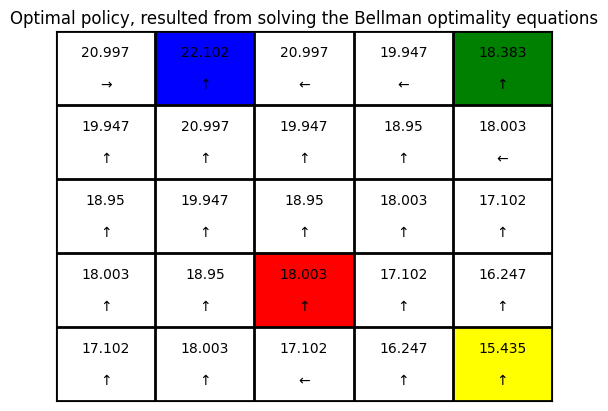

In [ ]:
optimal_policy_Bellman, values_Bellman = optimal_Bellman(grid_size=5, gamma=0.95)
plot_Bellman,ax_Bellman = plot_value_policy(np.round(values_Bellman, decimals=3), optimal_policy_Bellman)
ax_Bellman.title.set_text('Optimal policy, resulted from solving the Bellman optimality equations')
plt.show()

### Plot the result provided by the policy iteration with iterative policy evaluation

<ipython-input-10-ab143005186a>:25: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(patches.Rectangle((j-0.5, 4-i-0.5), 1, 1, fill=True, color=color, edgecolor='black'))


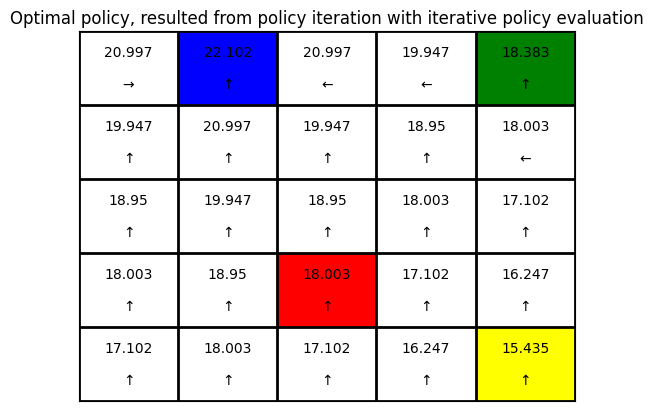

In [11]:
optimal_policy_PI, values_PI = run_policy_iteration_with_permutation(episodes=10000, gamma=gamma)

plot_vi,ax_vi = plot_value_policy(np.round(values_PI, decimals=3), optimal_policy_PI)
ax_vi.title.set_text('Optimal policy, resulted from policy iteration with iterative policy evaluation')
plt.show()

### Plot the result provided by the value iteration method

<ipython-input-65-ab143005186a>:25: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(patches.Rectangle((j-0.5, 4-i-0.5), 1, 1, fill=True, color=color, edgecolor='black'))


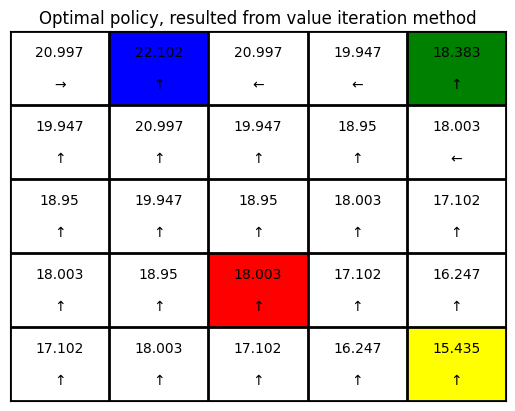

Value estimation method converged after 302 iterations
Delta = 9.857690912440376e-07


In [ ]:
plot_vi,ax_vi = plot_value_policy(np.round(V_vi, decimals=3), policy_vi)
ax_vi.title.set_text('Optimal policy, resulted from value iteration method')
plt.show()

print(f"Value estimation method converged after {iter_vi} iterations")
print(f"Delta = {delta_vi}")